In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline

import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rs
from sklearn.metrics import mean_absolute_error as mae

# to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



HERE I HAVE CREATED A FUNCTION TO CALL FOR LOADING DATA, THIS WAY DIFFERENT VARIABLES CAN EASILY BE ASSIGNED TO DIFFERENT DIMENSIONS OF THE DATA BEING USED

In [2]:
def get_data(name,lim):
    
   fetch_data = pd.read_csv(name)
   return fetch_data

In [3]:
#LOAD DATABASE

df = get_data('execution_database.csv',1)
df = df.dropna() #Drops missing values in the dataset


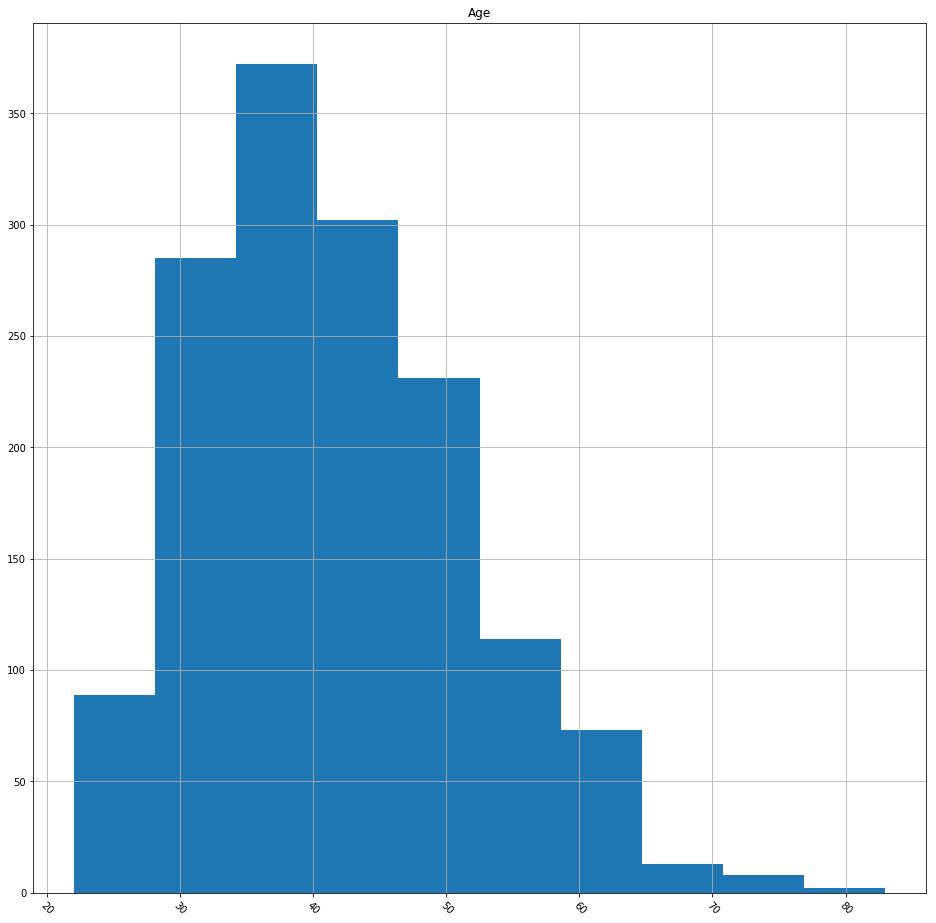

In [4]:
# Plot histogram grid
df.hist(figsize=(16,16), xrot=-45) ## Display the labels rotated by 45 degress

# Clear the text "residue"
plt.show()


The next few cells are just peeking at the data in question. Scroll over if uninterested.

In [5]:
df.describe() #Here, I just want to look at the components of the data which I am interested in

,Age
count,1489.000000
mean,41.791807
std,9.676538
min,22.000000
25%,34.000000
50%,40.000000
75%,48.000000
max,83.000000


EXECUTIONS BY RACE

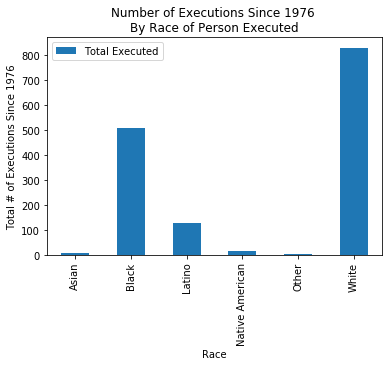

In [126]:
executions_by_race = df.groupby(['Race'], as_index=False)['Name'].count()
executions_by_race.rename(columns={'Name':'Total Executed'}, inplace=True)
ax = executions_by_race.plot.bar(x='Race', y='Total Executed', title='Number of Executions Since 1976 \nBy Race of Person Executed')
label = plt.ylabel("Total # of Executions Since 1976")
plt.show()

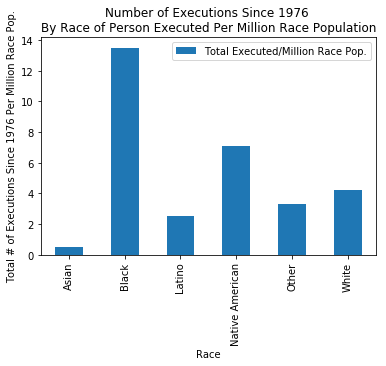

In [127]:
census_2010_numbers = {'Asian':14465124,'Black':37685848,'Latino':50477594, 'Native American':2247098, 'Other':604265, 'White':196817552}
for index, row in executions_by_race.iterrows():
    executions_by_race.loc[index, 'Total Executed/Million Race Pop.'] = (float(row['Total Executed'])/census_2010_numbers[row['Race']]) * 1000000
ax2 = executions_by_race.plot.bar(x='Race', y='Total Executed/Million Race Pop.', title='Number of Executions Since 1976 \nBy Race of Person Executed Per Million Race Population')
label = plt.ylabel("Total # of Executions Since 1976 Per Million Race Pop.")
plt.show()

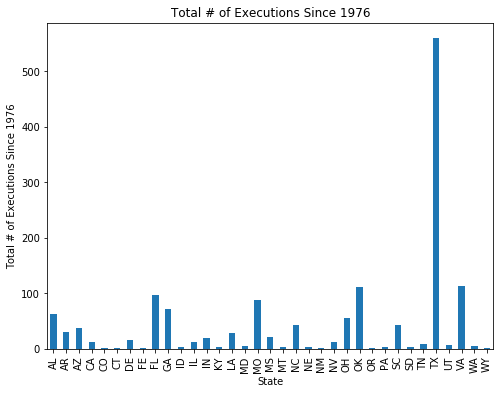

In [128]:
executions_by_state = df.groupby(['State'])['Name'].count()
ax = executions_by_state.plot.bar(x='State', figsize=(8,6), title="Total # of Executions Since 1976")
txt = plt.ylabel("Total # of Executions Since 1976")

TEXAS is the winner for the most executions

In [7]:
#gapminder[loc1,'continent'].value_counts()
df['Date'].value_counts().head()

12/09/1999    4
08/30/2000    3
01/07/2010    3
08/28/1987    3
04/28/1999    3
Name: Date, dtype: int64

In [8]:
#OLDEST PERSON EXECUTED OVERALL

oldest = df.max()

oldest

Date                                                     12/28/1984
Name                                                      Zane Hill
Age                                                              83
Sex                                                               m
Race                                                          White
Victim_Race_Sex     6 Black Male(s)1 White Female(s)1 White Male(s)
State                                                            WY
Region                                                            W
Method                                             Lethal Injection
Juvenile                                                        Yes
Federal                                                         Yes
Volunteer                                                       Yes
Foreign National                                                Yes
County                                                         Yuma
dtype: object

In [9]:
#df[df['A'].str.contains("hello")]
#SEARCH FOR PART OF NAME
name = df.loc[df['Name'].str.contains('Bundy')]
name

,Date,Name,Age,Sex,Race,Victim_Race_Sex,State,Region,Method,Juvenile,Federal,Volunteer,Foreign National,County
270,01/24/1989,Theodore Bundy,42,m,White,1 White Female(s),FL,S,Electrocution,No,No,No,No,Columbia


In [10]:
#SEARCH WHERE VICTIM(S) WERE FEMALE
victim = df.loc[df['Victim_Race_Sex'].str.contains("Female") == True]
victim.head()

,Date,Name,Age,Sex,Race,Victim_Race_Sex,State,Region,Method,Juvenile,Federal,Volunteer,Foreign National,County
0,01/10/1986,James Roach,25,m,White,1 White Male(s)1 White Female(s),SC,S,Electrocution,Yes,No,No,No,Richland
1,01/11/1985,Joseph Shaw,29,m,White,1 White Male(s)1 White Female(s),SC,S,Electrocution,No,No,No,No,Richland
4,01/06/1994,Keith Wells,31,m,White,1 White Male(s)1 White Female(s),ID,W,Lethal Injection,No,No,Yes,No,Ada
6,01/12/2000,Earl Heiselbertz,48,m,White,2 White Female(s),TX,S,Lethal Injection,No,No,No,No,Sabine
8,01/04/1985,David Martin,32,m,White,2 White Male(s)2 White Female(s),LA,S,Electrocution,No,No,No,No,Lafourche Parish


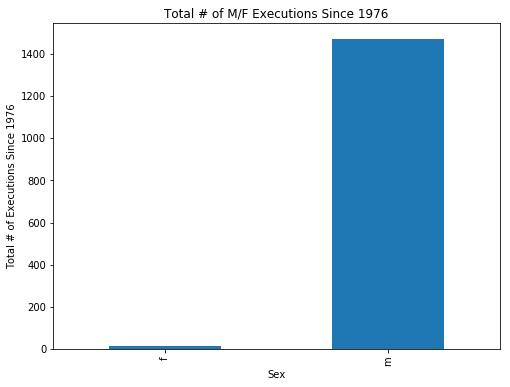

In [133]:
executions_by_state = df.groupby(['Sex'])['Name'].count()
ax = executions_by_state.plot.bar(x='Sex', figsize=(8,6), title="Total # of M/F Executions Since 1976")
txt = plt.ylabel("Total # of Executions Since 1976")

In [11]:
#SEARCH WHERE METHOD WAS ELECTROCUTION
elec = df.loc[df['Method'] == 'Electrocution']
elec.head()

,Date,Name,Age,Sex,Race,Victim_Race_Sex,State,Region,Method,Juvenile,Federal,Volunteer,Foreign National,County
0,01/10/1986,James Roach,25,m,White,1 White Male(s)1 White Female(s),SC,S,Electrocution,Yes,No,No,No,Richland
1,01/11/1985,Joseph Shaw,29,m,White,1 White Male(s)1 White Female(s),SC,S,Electrocution,No,No,No,No,Richland
8,01/04/1985,David Martin,32,m,White,2 White Male(s)2 White Female(s),LA,S,Electrocution,No,No,No,No,Lafourche Parish
14,01/09/1985,Roosevelt Green,28,m,Black,1 White Female(s),GA,S,Electrocution,No,No,No,No,Brooks
20,01/10/1997,Billy Waldrop,44,m,White,1 White Male(s),AL,S,Electrocution,No,No,No,No,Talladega


In [131]:
#SEARCH WHERE AGE => X, AND SEX = M/F
df_n = df.loc[df['Age'] >= 61] [df['Sex'] == 'm']

df_n.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Date,Name,Age,Sex,Race,Victim_Race_Sex,State,Region,Method,Juvenile,Federal,Volunteer,Foreign National,County
48,02/01/2001,D.L. Jones,61,m,White,1 White Male(s),OK,S,Lethal Injection,No,No,No,No,Comanche
97,04/09/2003,Earl Bramblett,61,m,White,1 White Male(s)3 White Female(s),VA,S,Electrocution,No,No,No,No,Roanoke
103,05/02/1997,Walter Hill,62,m,Black,2 Black Male(s)1 Black Female(s),AL,S,Electrocution,No,No,No,No,Jefferson
111,05/05/1999,Clydell Coleman,62,m,Black,1 Black Female(s),TX,S,Lethal Injection,No,No,No,No,McLennan
190,07/02/2003,Hilton Crawford,64,m,White,1 White Male(s),TX,S,Lethal Injection,No,No,No,No,Montgomery


In [13]:
# AVERAGE OVERALL AGE
age_df = df.loc[df['Age']]
age_df.mean()

Age    37.876427
dtype: float64

MY APOLOGIES TO TEXAS, THEY ARE JUST AN EASY STATE TO PICK ON IN THIS CASE

In [14]:
#THE OLDEST PERSON EXECUTED IN TEXAS WAS

tx_df = df.loc[df['State']=='TX']
tx_df.max()

Date                      12/18/1986
Name                  Yosvanis Valle
Age                               67
Sex                                m
Race                           White
Victim_Race_Sex      4 White Male(s)
State                             TX
Region                             S
Method              Lethal Injection
Juvenile                         Yes
Federal                           No
Volunteer                        Yes
Foreign National                 Yes
County                          Wood
dtype: object

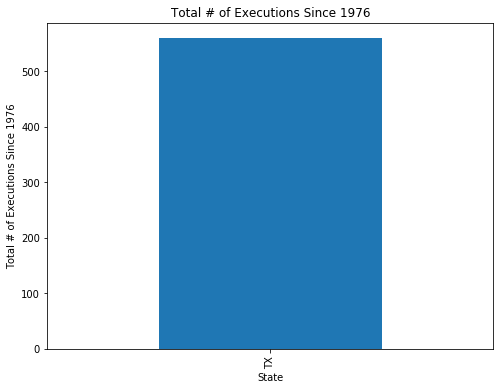

In [134]:
#tx_df.plot.hist(bins = 20)
#plt.title('AGE OF EXECUTED PEOPLE IN TEXAS')

#tx_df['Age'].value_counts().plot(kind='hist')
#plt.title('Amount of Murders by AGE')
#plt.xlabel('Age')
#plt.ylabel('AMOUNT')
#sns.despine

executions_by_state = tx_df.groupby(['State'])['Name'].count()
ax = executions_by_state.plot.bar(x='State', figsize=(8,6), title="Total # of Executions Since 1976")
txt = plt.ylabel("Total # of Executions Since 1976")

In [16]:
#THE YOUNGEST PERSON EXECUTED IN TEXAS WAS

tx_df = df.loc[df['State']=='TX']
tx_df.min()

Date                       01/04/1995
Name                      Aaron Foust
Age                                24
Sex                                 f
Race                            Asian
Victim_Race_Sex     1 Asian Female(s)
State                              TX
Region                              S
Method               Lethal Injection
Juvenile                           No
Federal                            No
Volunteer                          No
Foreign National                   No
County                       Anderson
dtype: object

In [17]:
#Are there "Other" values in Race?

Race = df.loc[df['Race']=='Other']
Race

,Date,Name,Age,Sex,Race,Victim_Race_Sex,State,Region,Method,Juvenile,Federal,Volunteer,Foreign National,County
403,11/14/2002,Mir Aimal Kasi,38,m,Other,1 White Male(s),VA,S,Lethal Injection,No,No,No,Yes,Fairfax
411,12/06/2001,Sahib Al-Mosawi,53,m,Other,1 Other Male(s)1 Other Female(s),OK,S,Lethal Injection,No,No,No,Yes,Oklahoma


In [18]:
date_range = df.loc[df['State'] == 'TX']
date_range.head()

,Date,Name,Age,Sex,Race,Victim_Race_Sex,State,Region,Method,Juvenile,Federal,Volunteer,Foreign National,County
6,01/12/2000,Earl Heiselbertz,48,m,White,2 White Female(s),TX,S,Lethal Injection,No,No,No,No,Sabine
13,01/09/2001,Jack Clark,37,m,White,1 Latino Female(s),TX,S,Lethal Injection,No,No,No,No,Lubbock
15,01/07/1988,Robert Streetman,27,m,White,1 White Female(s),TX,S,Lethal Injection,No,No,No,No,Hardin
17,01/04/1995,Jesse Jacobs,44,m,White,1 White Female(s),TX,S,Lethal Injection,No,No,No,No,Montgomery
21,01/05/1999,John Moody,46,m,White,1 White Female(s),TX,S,Lethal Injection,No,No,No,No,Taylor


A LINEAR REGRESSION MODEL SEEMS TO BE THE BEST APPROACH, SINCE WE ARE DEALING WITH PAST EVENTS

In [21]:
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import train_test_split


In [54]:
reg = LinearRegression()

HERE, I HAVE TO DO SOME DATA CLEANING SINCE I CANNOT DROP CERTAIN VALUES, SUCH AS GENDER AND 
RACE.
HERE, WHITE = 1, BLACK = 2, Native American = 3, Latino = 4, Asian = 5

In [55]:
df.Sex.replace(['m', 'f'], [0, 1], inplace=True)
df.Race.replace(['White', 'Black','Native American','Latino','Asian','Other'], [1, 2, 3, 4, 5, 0], inplace=True)
#df.dropna(axis='columns')
#df.dropna()

In [56]:
train1 = df.drop(['Date','Name','State','Juvenile','Method','Victim_Race_Sex','Region','Federal','Volunteer','Foreign National','County'],axis=1)

In [57]:
labels = df['Sex']

In [58]:
x_train , x_test , y_train , y_test = train_test_split(train1, labels, test_size = 0.20,random_state =2)


STANDARDIZE TRAININING SET

In [59]:
train_mean = x_train.mean()
train_std = x_train.std()


In [60]:
## Standardize the train data set
x_train = (x_train - train_mean) / train_std

In [61]:
## Check for mean and std dev.
x_train.describe()

,Age,Sex,Race
count,1.191000e+03,1.191000e+03,1.191000e+03
mean,1.146112e-16,1.903972e-17,-2.889749e-18
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.021849e+00,-1.128911e-01,-7.074442e-01
25%,-7.947270e-01,-1.128911e-01,-7.074442e-01
50%,-7.890602e-02,-1.128911e-01,-7.074442e-01
75%,6.369150e-01,-1.128911e-01,3.997385e-01
max,4.216020e+00,8.850659e+00,3.721286e+00


In [62]:
## Note: We use train_mean and train_std_dev to standardize test data set
x_test = (x_test - train_mean) / train_std

In [63]:
## Predict Train results
y_train_pred = np.ones(y_train.shape[0])*y_train.mean()

In [64]:
## Predict Test results
y_pred = np.ones(y_test.shape[0])*y_train.mean()

In [65]:
#x_test.fillna(x_train.mean(), inplace=True)
#x_test = x_test.fillna(x_train.mean())
#x_test._is_view
x_test.fillna(x_test.mean()).head(10)

,Age,Sex,Race
786,-0.487947,-0.112891,0.399738
352,1.045956,-0.112891,-0.707444
916,0.534655,-0.112891,-0.707444
1430,-0.896987,-0.112891,-0.707444
68,0.023354,-0.112891,0.399738
745,-0.692467,-0.112891,0.399738
1269,-0.487947,-0.112891,0.399738
673,-1.306028,-0.112891,2.614104
1148,0.739175,-0.112891,-0.707444
45,-0.385686,-0.112891,1.506921


In [66]:
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [67]:
reg.score(x_test,y_test)

1.0

In [68]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [69]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [70]:
clf.score(x_test,y_test)

0.9999923068226558

In [71]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [72]:
y_pred = reg.predict(x_test)

In [73]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [74]:
pca = PCA()

In [75]:
pca.fit_transform(scale(train1))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


array([[-7.36198313e-01,  5.81624685e-02, -1.72334371e+00],
       [-4.60895219e-01, -2.90106889e-02, -1.42737168e+00],
       [-1.24573365e+00,  5.31821389e-01,  2.35646534e+00],
       ...,
       [-2.17785690e-01, -1.88411823e-03,  3.76522728e-01],
       [-8.32779009e-01,  4.01061653e-01,  2.80042340e+00],
       [ 1.02107823e+00, -3.94163327e-01,  1.70839689e+00]])

Here, I have to put gender and race back into their original values, since I do not want them to remain numbers.

In [98]:
df.Sex.replace([0, 1], ['m', 'f'], inplace=True)
df.Race.replace([1, 2, 3, 4, 5, 0], ['White', 'Black','Native American','Latino','Asian','Other'],inplace=True)



In [123]:
df['Sex'].value_counts()

m    1473
f      16
Name: Sex, dtype: int64

In [124]:
df['Race'].value_counts()

White              829
Black              509
Latino             126
Native American     16
Asian                7
Other                2
Name: Race, dtype: int64

In [125]:
df['Age'].value_counts()

38    79
37    73
39    72
43    62
47    60
33    59
41    58
42    57
40    56
34    53
31    50
32    49
35    48
46    46
36    44
44    44
49    43
30    40
45    35
48    35
29    34
51    34
52    30
27    29
28    29
50    29
53    25
54    20
55    18
56    18
58    17
61    17
59    16
57    16
62    14
63    13
26    12
25    11
60     8
66     6
64     5
24     5
65     4
67     3
74     3
72     2
23     2
83     1
77     1
71     1
75     1
76     1
22     1
Name: Age, dtype: int64

CONCLUSION:

I was unable to find a strong correlation between age, sex and race and those who die from the death penalty. I might find capital punishment objectionable, but using my above methods, the there does not appear to be a preferred "victim" of this. I would have to explore the data further to find any stronger links, and would have to include more data sets than used in this project. Although, it does appear that white males are the primary recipients of the death penalty. Age does not seem to be a discriminating factor, at least based on this current data set